# Paleo-Detector Analysis Pipeline

This notebook provides a complete, end-to-end workflow for the phenomenological analysis of paleo-detectors. It is designed to calculate the expected nuclear recoil track spectra from both external cosmic ray muon signals and various internal/atmospheric backgrounds.

The pipeline is built around the *mineral_utils.py* module, which contains the *Paleodetector* class. This class acts as the physics engine, handling all low-level data processing and calculations. The notebook serves as a high-level interface to configure and orchestrate the analysis.

### Workflow Overview:

**1. Configuration:** All analysis parameters are defined in the configuration cells. This includes selecting the mineral from a library, defining the geological history of the sample (age, exposure time, deposition rate), and setting up the astrophysical scenarios for the cosmic ray flux.

**2. Initialization:** A Paleodetector object is created. This object automatically loads and caches all necessary input data, such as SRIM tables for ion ranges and pre-computed Geant4 results for muon interactions.

**3. Background Calculation:** The notebook calculates the track spectra for the primary background sources:

- Spontaneous Fission: Tracks from the spontaneous fission of Uranium-238 impurities within the mineral.

- Radiogenic Neutrons: Tracks from neutrons produced by (α,n) reactions in the surrounding rock.

- Neutrinos: Tracks from coherent elastic neutrino-nucleus scattering.

**7. Signal Calculation:** For each defined astrophysical scenario, the notebook calculates the track spectrum from cosmic ray muons. This core step includes a sophisticated model for a time-variant cosmic ray flux and the continuous deposition of overburden, which attenuates the signal over the exposure window. The time integration is performed in parallel for efficiency.

**8. Analysis & Plotting:** The final signal and background components are combined to produce the summary plots, showing the total expected number of tracks as a function of track length.


In [2]:
import yaml
import numpy as np
from matplotlib import pyplot as plt

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# --- Custom Utility Module ---
from mineral_utils import Paleodetector

print("Libraries imported successfully.")

Libraries imported successfully.


/home/cgalelli/miniconda3/envs/paleo/lib/python3.12/site-packages/WIMpy/DMUtils.py:41: UserWarning: Input line 1 contained no data and will not be counted towards `max_rows=50000`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `itertools.islice`.
Please see the 1.23 release notes for an example on how to do this.  If you wish to ignore this warning, use `warnings.filterwarnings`.  This warning is expected to be removed in the future and is given only once per `loadtxt` call.
  target_list = np.loadtxt(os.path.dirname(os.path.realpath(__file__)) + "/Nuclei.txt", usecols=(0,), dtype=bytes).astype(str)


In [3]:
mineral_name =  "Olivine"  # Must match a key in MINERAL_LIBRARY

sample_mass_kg =  0.0002       # Sample mass in kg (e.g., 0.01 for 10g)

x_bins = np.linspace(0, 100000, 100)        #Track length bins in nm
x_mids = x_bins[:-1] + np.diff(x_bins) / 2

In [4]:
CONFIG = yaml.safe_load(open('Data/basic_config.yaml', 'r'))
MINERAL_LIBRARY = yaml.safe_load(open('Data/mineral_library.yaml', 'r'))

In [5]:
scenario_config_simple = {
    'name': 'simple',
    'event_fluxes': {
        0.: ('H3a', 'H3a'),
    }
}

scenario_config_simple_enhanced = {
    'name': 'simple_enhanced',
    'event_fluxes': {
        0.: ('H3a_enhanced', 'H3a_enhanced'),
        5.: ('H3a', 'H3a'),
        40.: ('H3a', 'H3a'),
    }
}

scenario_config_SN250_enhanced = {
    'name': 'SN250_enhanced',
    'event_fluxes': {
        0.: ('SN250pc_10kyr_enhanced', 'SN250pc_10kyr_enhanced'),
        2.: ('SN250pc_12kyr_enhanced', 'SN250pc_12kyr_enhanced'),
        5.: ('SN250pc_15kyr_enhanced', 'SN250pc_15kyr_enhanced'),
        10.: ('SN250pc_20kyr', 'SN250pc_20kyr'),
        20.: ('SN250pc_30kyr', 'SN250pc_30kyr'),
        30.: ('SN250pc_40kyr', 'SN250pc_40kyr'),
        40.: ('H3a', 'H3a'),
    }
}

scenario_config_SN250 = [{
    'name': 'SN250_40',
    'event_fluxes': {
        0.: ('SN250pc_10kyr', 'SN250pc_10kyr'),
        10.: ('SN250pc_20kyr', 'SN250pc_20kyr'),
        20.: ('SN250pc_30kyr', 'SN250pc_30kyr'),
        30.: ('SN250pc_40kyr', 'SN250pc_40kyr'),
        40.: ('H3a', 'H3a'),
    }
},
{
    'name': 'SN250_30',
    'event_fluxes': {
        0.: ('SN250pc_20kyr', 'SN250pc_20kyr'),
        10.: ('SN250pc_30kyr', 'SN250pc_30kyr'),
        15.: ('SN250pc_35kyr', 'SN250pc_35kyr'),
        20.: ('SN250pc_40kyr', 'SN250pc_40kyr'),
        25.: ('SN250pc_45kyr', 'SN250pc_45kyr'),
        30.: ('H3a', 'H3a'),
    }
},
{
    'name': 'SN250_13',
    'event_fluxes': {
        0.: ('SN250pc_35kyr', 'SN250pc_35kyr'),
        3.: ('SN250pc_40kyr', 'SN250pc_40kyr'),
        8.: ('SN250pc_45kyr', 'SN250pc_45kyr'),
        13.: ('H3a', 'H3a'),
    }
},
{
    'name': 'SN250_11',
    'event_fluxes': {
        0.: ('SN250pc_35kyr', 'SN250pc_35kyr'),
        1.: ('SN250pc_40kyr', 'SN250pc_40kyr'),
        6.: ('SN250pc_45kyr', 'SN250pc_45kyr'),
        11.: ('H3a', 'H3a'),
    }
},
{
    'name': 'SN250_10',
    'event_fluxes': {
        0.: ('SN250pc_40kyr', 'SN250pc_40kyr'),
        5.: ('SN250pc_45kyr', 'SN250pc_45kyr'),
        10.: ('H3a', 'H3a'),
    }
},
{
    'name': 'SN250_8',
    'event_fluxes': {
        0.: ('SN250pc_40kyr', 'SN250pc_40kyr'),
        3.: ('SN250pc_45kyr', 'SN250pc_45kyr'),
        8.: ('H3a', 'H3a'),
    }
},
{
    'name': 'SN250_7',
    'event_fluxes': {
        0.: ('SN250pc_40kyr', 'SN250pc_40kyr'),
        2.: ('SN250pc_45kyr', 'SN250pc_45kyr'),
        7.: ('H3a', 'H3a'),
    }
},
]

In [6]:
exposure_times = np.array([41.4, 30., 13.1, 10.96, 9.5, 8.64, 7.65])
exposure_times_err = np.array([1., 2., 0.7, 0.15, 0.5, 0.06, 0.12])
names = np.array(["Laschamp", "Lemptegy", "Come", "Dome", "Pariou", "Lavache", "Montcineyre"], dtype=str)


In [7]:
# --- Setup & Verification ---
mineral_config = MINERAL_LIBRARY.get(mineral_name)
if not mineral_config:
    raise ValueError(f"Mineral '{mineral_name}' not found in MINERAL_LIBRARY.")

mineral = Paleodetector(mineral_config)

Initialized Paleodetector: Olivine


## Calculation of Track Spectra

With the Paleodetector object initialized and all necessary data loaded, we can now proceed with the core physics calculations. The following cells will compute the differential track rate (dR/dx) for each relevant physical process and then integrate these rates over the sample's lifetime to find the total expected number of tracks in each track length bin.

### Calculation Steps:

**1. Backgrounds:** We first calculate the spectra for the steady-state backgrounds that accumulate over the entire geological age of the sample. These include spontaneous fission, radiogenic neutrons, and atmospheric neutrinos.

**2. Muon Signal:** Next, we compute the primary signal from cosmic ray muons. The integrate_muon_signal_spectrum_parallel function is used for this. It performs a numerical integration over the specified exposure_window_kyr, accounting for two key time-dependent effects at each step:

- The evolution of the cosmic ray flux, which is interpolated from the files defined in the scenario_config.

- The increase in shielding due to the continuous deposition_rate_m_kyr.

**3. Final Plot:** Finally, all calculated track components (signals and backgrounds) are summed and plotted to visualize the expected final track spectrum in the detector.

In [8]:
total_fission_tracks = np.array([mineral.integrate_fission_spectrum(x_bins, age/1000., sample_mass_kg) for age in exposure_times])

Calculating spontaneous fission background...


/home/cgalelli/Documents/PrimusCode/mineral_utils.py:468: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  total_tracks = [quad(total_tracks_interp, x_bins[i], x_bins[i+1])[0] for i in range(len(x_mids))]


Calculating spontaneous fission background...
Calculating spontaneous fission background...
Calculating spontaneous fission background...
Calculating spontaneous fission background...
Calculating spontaneous fission background...
Calculating spontaneous fission background...


In [9]:
total_neutron_tracks = np.array([mineral.integrate_neutron_spectrum(x_bins, age/1000., sample_mass_kg) for age in exposure_times])

Calculating radiogenic neutron background...


/home/cgalelli/Documents/PrimusCode/mineral_utils.py:354: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  total_tracks = [quad(total_tracks_interp, x_bins[i], x_bins[i+1])[0] for i in range(len(x_mids))]


Calculating radiogenic neutron background...
Calculating radiogenic neutron background...
Calculating radiogenic neutron background...
Calculating radiogenic neutron background...
Calculating radiogenic neutron background...
Calculating radiogenic neutron background...


In [10]:
total_muon_tracks = np.array([mineral.integrate_muon_signal_spectrum_parallel(x_bins, scenario_config=scenario_config_simple, energy_bins_gev=CONFIG["geant4_energy_bins_gev"], exposure_window_kyr=age, sample_mass_kg = sample_mass_kg, nsteps=5) for age in exposure_times])

100%|██████████| 6/6 [00:28<00:00,  4.80s/it]
/home/cgalelli/Documents/PrimusCode/mineral_utils.py:782: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  total_tracks = [quad(total_tracks_interp, x_bins[i], x_bins[i+1])[0] for i in range(len(x_mids))]
/home/cgalelli/Documents/PrimusCode/mineral_utils.py:782: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  total_tracks = [quad(total_tracks_interp, x_bins[i], x_bins[i+1])[0] for i in range(len(x_mids))]
100%|██████████

In [11]:
total_muon_tracks_SN250 = np.array([mineral.integrate_muon_signal_spectrum_parallel(x_bins, scenario_config=scenario_config_SN250[i], energy_bins_gev=CONFIG["geant4_energy_bins_gev"], exposure_window_kyr=age, sample_mass_kg = sample_mass_kg, nsteps=int(age)) for i, age in enumerate(exposure_times)])

100%|██████████| 42/42 [03:44<00:00,  5.35s/it]
/home/cgalelli/Documents/PrimusCode/mineral_utils.py:778: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  total_drdx = [quad(drdx_interpolator, 0, exposure_window_kyr)[0] for drdx_interpolator in drdx_interpolators]
100%|██████████| 8/8 [00:51<00:00,  6.48s/it]


In [12]:
muon_tracks_enhanced = mineral.integrate_muon_signal_spectrum_parallel(x_bins, scenario_config=scenario_config_simple_enhanced, energy_bins_gev=CONFIG["geant4_energy_bins_gev"], exposure_window_kyr=exposure_times[0], sample_mass_kg = sample_mass_kg, nsteps=41)
muon_tracks_SN250_enhanced = mineral.integrate_muon_signal_spectrum_parallel(x_bins, scenario_config=scenario_config_SN250_enhanced, energy_bins_gev=CONFIG["geant4_energy_bins_gev"], exposure_window_kyr=exposure_times[0], sample_mass_kg = sample_mass_kg, nsteps=41)

100%|██████████| 42/42 [03:25<00:00,  4.88s/it]
/home/cgalelli/Documents/PrimusCode/mineral_utils.py:778: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  total_drdx = [quad(drdx_interpolator, 0, exposure_window_kyr)[0] for drdx_interpolator in drdx_interpolators]


In [13]:
total_muon_tracks_enhanced = total_muon_tracks.copy()
total_muon_tracks_SN250_enhanced = total_muon_tracks_SN250.copy()

total_muon_tracks_enhanced[0] = muon_tracks_enhanced
total_muon_tracks_SN250_enhanced[0] = muon_tracks_SN250_enhanced


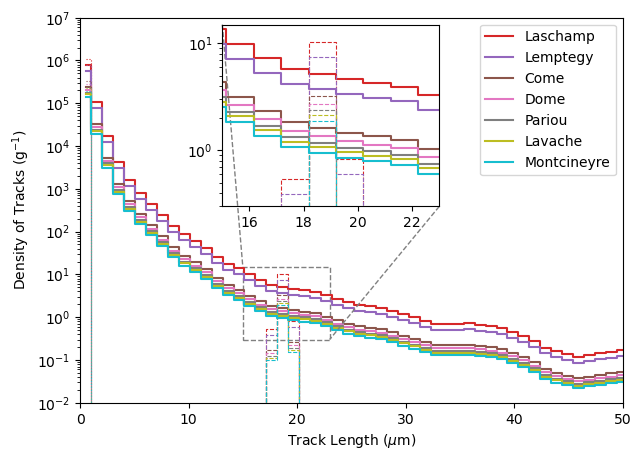

In [14]:
fig, ax = plt.subplots(figsize=[7, 5])

for i, name in enumerate(names):
    ax.step(x_mids/1000, total_fission_tracks[i]/(1e3*sample_mass_kg), color=f'C{i+3}', linestyle='dashed', linewidth=0.8, where='mid')
    ax.step(x_mids/1000, total_neutron_tracks[i]/(1e3*sample_mass_kg), color=f'C{i+3}', linestyle='dotted', linewidth=0.8, where='mid')
    ax.step(x_mids/1000, total_muon_tracks[i]/(1e3*sample_mass_kg), color=f'C{i+3}', label=f"{names[i]}", where='mid')

axins = zoomed_inset_axes(ax, zoom=2.5,bbox_to_anchor=(0.275, 0.6, 0.4, 0.4), bbox_transform=ax.transAxes)

for i, name in enumerate(names):
    axins.step(x_mids/1000, total_fission_tracks[i]/(1e3*sample_mass_kg), color=f'C{i+3}', linestyle='dashed', linewidth=0.8, where='mid')
    axins.step(x_mids/1000, total_neutron_tracks[i]/(1e3*sample_mass_kg), color=f'C{i+3}', linestyle='dotted', linewidth=0.8, where='mid')
    axins.step(x_mids/1000, total_muon_tracks[i]/(1e3*sample_mass_kg), color=f'C{i+3}', label=f"{names[i]}", where='mid')

axins.set_xlim(15, 23)
axins.set_ylim(0.3, 15)
axins.set_yscale('log')
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5", linestyle='--')

#ax.set_title(f"Track density distribution in {mineral_name}")
ax.set_xlabel(r"Track Length ($\mu$m)")
ax.set_ylabel(r"Density of Tracks (g$^{-1}$)")
ax.set_yscale("log")
ax.set_ylim(1e-2, 1e7)
ax.set_xlim(0, 50)
ax.legend()
plt.savefig("Plots/CDP_track_number_per_gram.png", dpi=500)
plt.show()

In [15]:
summed_target = np.sum(total_muon_tracks[..., x_mids>4000], axis=-1)
summed_SN250 = np.sum(total_muon_tracks_SN250[..., x_mids>4000], axis=-1)
summed_enhanced = np.sum(total_muon_tracks_enhanced[..., x_mids>4000], axis=-1)
summed_SN250_enhanced = np.sum(total_muon_tracks_SN250_enhanced[..., x_mids>4000], axis=-1)

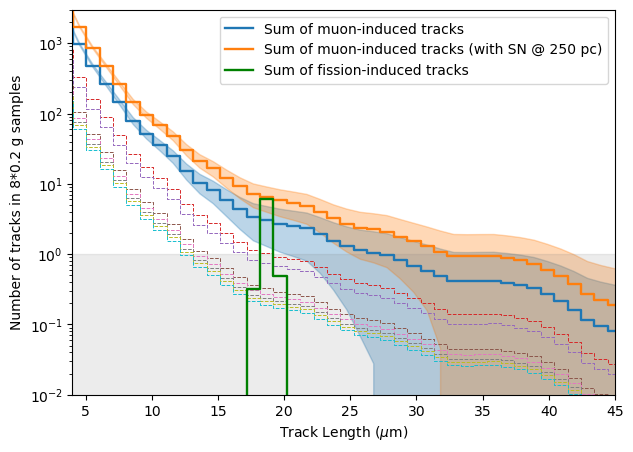

In [16]:
fig, ax = plt.subplots(figsize=[7, 5])

for i, name in enumerate(names):
    ax.step(x_mids/1000, total_muon_tracks[i], linestyle='--', color=f'C{i+3}',linewidth=0.7, where='mid')

sum_muons = np.sum(total_muon_tracks, axis=0)
sum_muons_SN250 = np.sum(total_muon_tracks_SN250, axis=0)

ax.step(x_mids/1000, sum_muons, label=f"Sum of muon-induced tracks", linewidth=1.7, color='C0', where='mid')
ax.step(x_mids/1000, sum_muons_SN250, label=f"Sum of muon-induced tracks (with SN @ 250 pc)", linewidth=1.7, color='C1', where='mid')
ax.step(x_mids/1000, np.sum(total_fission_tracks, axis=0), label=f"Sum of fission-induced tracks", color='green', linewidth=1.7, where='mid')
ax.fill_between(x_mids/1000, sum_muons-np.sqrt(sum_muons), sum_muons+np.sqrt(sum_muons), color='C0', alpha=0.3)
ax.fill_between(x_mids/1000, sum_muons_SN250-np.sqrt(sum_muons_SN250), sum_muons_SN250+np.sqrt(sum_muons_SN250), color='C1', alpha=0.3)

ax.fill_between(x_mids/1000, 1e-3, 1, color='grey', alpha=0.15)

#ax.set_title(f"Total track count distribution in {mineral_name}")
ax.set_xlabel(r"Track Length ($\mu$m)")
ax.set_ylabel(r"Number of tracks in 8*0.2 g samples")
ax.set_yscale("log")
ax.set_ylim(1e-2, 3e3)
ax.set_xlim(4, 45)
ax.legend()
plt.savefig("Plots/CDP_total_tracks_collection.png", dpi=500)
plt.show()

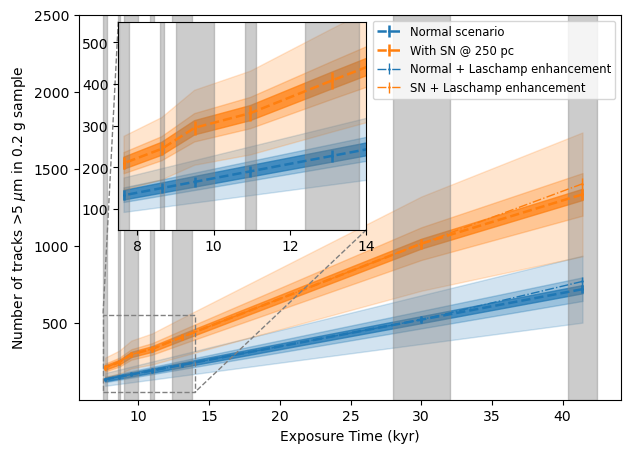

In [17]:
fig, ax = plt.subplots(figsize=[7, 5])

ax.errorbar(exposure_times, summed_target, yerr= np.sqrt(summed_target), label="Normal scenario", linewidth=1.8, color='C0', marker='o', markersize=1., linestyle='--', capsize=0)
ax.fill_between(exposure_times, summed_target-np.sqrt(summed_target), summed_target+np.sqrt(summed_target), color='C0', alpha=0.7)
ax.fill_between(exposure_times, summed_target-np.sqrt(summed_target+(0.1*summed_target)**2), summed_target+np.sqrt(summed_target+(0.1*summed_target)**2), color='C0', alpha=0.3)
ax.fill_between(exposure_times, summed_target-np.sqrt(summed_target+(0.3*summed_target)**2), summed_target+np.sqrt(summed_target+(0.3*summed_target)**2), color='C0', alpha=0.2)

ax.errorbar(exposure_times, summed_SN250, yerr= np.sqrt(summed_SN250), label="With SN @ 250 pc", linewidth=1.8, color='C1', marker='o', markersize=1., linestyle='--', capsize=0)
ax.fill_between(exposure_times, summed_SN250-np.sqrt(summed_SN250), summed_SN250+np.sqrt(summed_SN250), color='C1', alpha=0.7)
ax.fill_between(exposure_times, summed_SN250-np.sqrt(summed_SN250+(0.1*summed_SN250)**2), summed_SN250+np.sqrt(summed_SN250+(0.1*summed_SN250)**2), color='C1', alpha=0.3)
ax.fill_between(exposure_times, summed_SN250-np.sqrt(summed_SN250+(0.3*summed_SN250)**2), summed_SN250+np.sqrt(summed_SN250+(0.3*summed_SN250)**2), color='C1', alpha=0.2)

ax.errorbar(exposure_times, summed_enhanced, yerr= np.sqrt(summed_enhanced), label="Normal + Laschamp enhancement", linewidth=1., color='C0', marker='o', markersize=0.8, linestyle='-.', capsize=0)
ax.errorbar(exposure_times, summed_SN250_enhanced, yerr= np.sqrt(summed_SN250_enhanced), label="SN + Laschamp enhancement", linewidth=1., color='C1', marker='o', markersize=0.8, linestyle='-.', capsize=0)

for i, age in enumerate(exposure_times):
    ax.axvspan(age-exposure_times_err[i], age+exposure_times_err[i], color='grey', alpha=0.4)

axins = zoomed_inset_axes(ax, zoom=2.7, loc='upper left',bbox_to_anchor=(0.06, 0.6, 0.4, 0.4), bbox_transform=ax.transAxes)
axins.errorbar(exposure_times, summed_target, yerr= np.sqrt(summed_target), label="Normal scenario", linewidth=1.8, color='C0', marker='o', markersize=1., linestyle='--', capsize=0)
axins.fill_between(exposure_times, summed_target-np.sqrt(summed_target), summed_target+np.sqrt(summed_target), color='C0', alpha=0.7)
axins.fill_between(exposure_times, summed_target-np.sqrt(summed_target+(0.1*summed_target)**2), summed_target+np.sqrt(summed_target+(0.1*summed_target)**2), color='C0', alpha=0.3)
axins.fill_between(exposure_times, summed_target-np.sqrt(summed_target+(0.3*summed_target)**2), summed_target+np.sqrt(summed_target+(0.3*summed_target)**2), color='C0', alpha=0.2)

axins.errorbar(exposure_times, summed_SN250, yerr= np.sqrt(summed_SN250), label="With SN @ 250 pc", linewidth=1.8, color='C1', marker='o', markersize=1., linestyle='--', capsize=0)
axins.fill_between(exposure_times, summed_SN250-np.sqrt(summed_SN250), summed_SN250+np.sqrt(summed_SN250), color='C1', alpha=0.7)
axins.fill_between(exposure_times, summed_SN250-np.sqrt(summed_SN250+(0.1*summed_SN250)**2), summed_SN250+np.sqrt(summed_SN250+(0.1*summed_SN250)**2), color='C1', alpha=0.3)
axins.fill_between(exposure_times, summed_SN250-np.sqrt(summed_SN250+(0.3*summed_SN250)**2), summed_SN250+np.sqrt(summed_SN250+(0.3*summed_SN250)**2), color='C1', alpha=0.2)

for i, age in enumerate(exposure_times):
    axins.axvspan(age-exposure_times_err[i], age+exposure_times_err[i], color='grey', alpha=0.4)

axins.set_xlim(7.5, 14)
axins.set_ylim(50, 550)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5", linestyle='--')

ax.set_xlabel(r"Exposure Time (kyr)")
ax.set_ylabel(r"Number of tracks >5 $\mu$m in 0.2 g sample")
#ax.set_title("Time Evolution of Muon-Induced Tracks")
ax.set_ylim(1e0, 2.5e3)
ax.legend(fontsize='small', loc='upper right')
plt.savefig("Plots/CDP_time_evolution.png", dpi=500)
plt.show()

In [21]:
filepath = './Data/processed_recoils/Olivine_muon_recoil_simple_10.0kyr_0mwe.npz'
recoil_data = np.load(filepath)

x_bins_N = np.linspace(0, 10000, 100)        #Track length bins in nm
x_mids_N = x_bins_N[:-1] + np.diff(x_bins_N) / 2

drdx_muon = mineral._convert_recoil_to_track_spectrum(x_bins=x_bins, recoil_data=recoil_data, energy_bins_gev=CONFIG["geant4_energy_bins_gev"])
drdx_fission = mineral.calculate_fission_spectrum(x_bins)
drdx_neutron = mineral.calculate_neutron_spectrum(x_bins_N)

drdx_org = np.zeros_like(drdx_muon['total'])
drdx_result = np.zeros_like(drdx_muon['total'])
for name in recoil_data.files[1:]:
    if name != 'total' and name != 'Er_bins':
        if name in ['Mg', 'Fe', 'Si', 'O']:
            drdx_org += drdx_muon[name]
        else: drdx_result += drdx_muon[name]

Calculating spontaneous fission background...
Calculating radiogenic neutron background...


In [22]:
filepath_mod = './Data/processed_recoils/Olivine_muon_recoil_SN250_40_0.0kyr_0mwe.npz'
recoil_data_mod = np.load(filepath_mod)

drdx_muon_mod = mineral._convert_recoil_to_track_spectrum(x_bins=x_bins, recoil_data=recoil_data_mod, energy_bins_gev=CONFIG["geant4_energy_bins_gev"])

drdx_org_mod = np.zeros_like(drdx_muon['total'])
drdx_result_mod = np.zeros_like(drdx_muon['total'])
for name in recoil_data_mod.files[1:]:
    if name != 'total' and name != 'Er_bins':
        if name in ['Mg', 'Fe', 'Si', 'O']:
            drdx_org_mod += drdx_muon_mod[name]
        else: drdx_result_mod += drdx_muon_mod[name]

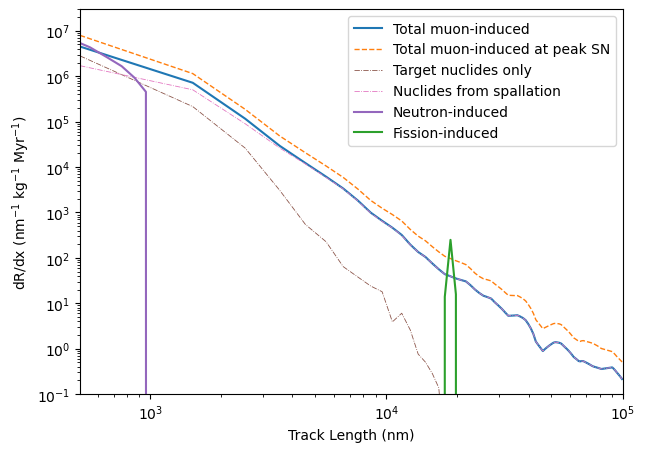

In [25]:
fig, ax = plt.subplots(figsize=[7, 5])

ax.plot(x_mids, drdx_muon['total'], label='Total muon-induced')
ax.plot(x_mids, drdx_muon_mod['total'], linestyle='--', linewidth=1., label='Total muon-induced at peak SN')
ax.plot(x_mids, drdx_org, linestyle='-.', linewidth=0.6, color='C5', label='Target nuclides only')
ax.plot(x_mids, drdx_result, linestyle='-.', linewidth=0.6, color='C6', label='Nuclides from spallation')
ax.plot(x_mids_N, drdx_neutron, linestyle='-', color = 'C4',label='Neutron-induced')
ax.plot(x_mids, drdx_fission, linestyle='-', color = 'C2',label='Fission-induced')

ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel(r"Track Length (nm)")
ax.set_ylabel(r"dR/dx (nm$^{-1}$ kg$^{-1}$ Myr$^{-1}$)")
#ax.set_title(f"Track rate spectrum in {mineral_name}")
ax.set_ylim(1e-1, 3e7)
ax.set_xlim(x_mids[0], x_bins[-1])
ax.legend()
plt.savefig("Plots/CDP_drdx.png", dpi=500)
plt.show()

